In [1]:
import jax
import jax.numpy as jnp
import jax.random as random
from jax.scipy.special import expit, logit
import numpy as np
from tqdm import tqdm
import numpyro
import numpyro.distributions as dist
import src.Aux_functions as aux
from itertools import combinations
import matplotlib.pyplot as plt 
import time 




In [2]:
key = random.PRNGKey(0)

# Generate some data
n = 500
triu_dim = n*(n-1)//2

x = random.normal(key, shape=(n,))*3
x2 = random.binomial(key, n=1, p=0.1, shape=(n,))
idx_pairs = list(combinations(range(len(x)), 2))
x_diff = jnp.array([abs(x[i] - x[j]) for i, j in idx_pairs])
x2_or = jnp.array([1 if (x2[i] + x2[j] == 1) else 0 for i, j in idx_pairs])


print(x.shape, x2.shape, x_diff.shape, x2_or.shape)

# Network data

df_edges = jnp.transpose(jnp.stack([x_diff, x2_or]))
theta = jnp.array([-3, 1.5])
gamma = jnp.array([1.1, 0.2, -1, 1])

triu_star_probs = expit(jnp.dot(df_edges, theta))
triu_star = random.binomial(key, n=1, p=triu_star_probs, shape=(triu_dim,))


triu_obs_probs = expit((triu_star * gamma[0]) + (1 - triu_star) * (gamma[1] + jnp.dot(df_edges, gamma[2:])))
triu_obs = random.binomial(key, n=1, p=triu_obs_probs, shape=(triu_dim,))

print(triu_star.shape, triu_obs.shape)

# Outcome data

mat_star = aux.Triu_to_mat(triu_star)
Z = random.binomial(key, n=1, p=0.5, shape=(n,))
exposures = jnp.dot(mat_star, Z)

df_nodes = jnp.transpose(jnp.stack([jnp.ones(n), Z, x, exposures]))
eta = jnp.array([-1, 3, -0.25, 3])

mean_y = jnp.dot(df_nodes, eta)
sig_y = 1

Y = random.normal(key, shape=(n,))*sig_y + mean_y

print(Y.shape)



(500,) (500,) (124750,) (124750,)
(124750,) (124750,)
(500,)


In [3]:
print(triu_star[1:5], "\n", triu_obs[1:5])

[0. 0. 0. 0.] 
 [1. 0. 0. 0.]


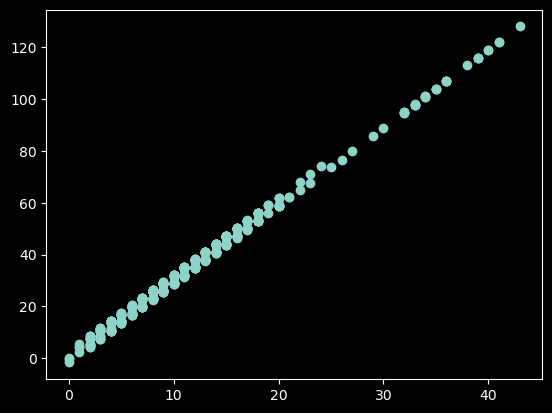

In [4]:
plt.scatter(exposures, Y)

In [9]:
@jax.jit
def A_star_cond_log_post(triu_star, triu_obs, df_edges, theta, gamma):
    logits_a_star = jnp.dot(df_edges, theta)
    a_star_log_likelihood = triu_star * (-jnp.log1p(jnp.exp(-logits_a_star))) + (1 - triu_star) * (-jnp.log1p(jnp.exp(logits_a_star)))

    logits_a_obs = (triu_star * gamma[0]) + (1 - triu_star) * (gamma[1] + jnp.dot(df_edges, gamma[2:]))
    a_obs_log_likelihood = triu_obs * (-jnp.log1p(jnp.exp(-logits_a_obs))) + (1 - triu_obs) * (-jnp.log1p(jnp.exp(logits_a_obs)))

    log_prob = a_star_log_likelihood + a_obs_log_likelihood 
    log_prob_sum = jnp.sum(log_prob)

    return log_prob_sum, log_prob

@jax.jit
def compute_exposures(triu_star, Z):
    mat_star = aux.Triu_to_mat(triu_star)
    return jnp.dot(mat_star, Z)

@jax.jit
def A_star_cond_log_post_with_Y(triu_star, triu_obs, df_edges, theta, gamma, Y, X, Z, eta):
    log_prob_sum_n, log_prob_n = A_star_cond_log_post(triu_star, triu_obs, df_edges, theta, gamma)
    # curr_a_star = aux.Triu_to_mat(triu_star)
    # exposures = jnp.dot(curr_a_star, Z)
    exposures = compute_exposures(triu_star, Z)
    df_nodes = jnp.transpose(jnp.stack([jnp.ones(n), Z, X, exposures]))
    mean_y = jnp.dot(df_nodes, eta)
    y_log_likelihood = - 0.5 * jnp.sum((Y - mean_y)**2)

    return log_prob_sum_n + y_log_likelihood, log_prob_n + y_log_likelihood


In [10]:
print(A_star_cond_log_post(triu_star, triu_obs, df_edges, theta, gamma))
print(A_star_cond_log_post_with_Y(triu_star, triu_obs, df_edges, theta, gamma, Y, x, Z, eta))

(Array(-53764.203, dtype=float32), Array([-0.40488562, -2.3433218 , -0.01463171, ..., -0.39524946,
       -0.1137819 , -3.2216356 ], dtype=float32))
(Array(-54012.17, dtype=float32), Array([-248.37363, -250.31206, -247.98337, ..., -248.36398, -248.08252,
       -251.19037], dtype=float32))


(124750,) (124750,)
-54012.17 
 [ -4.498211  -15.498867  -22.527515    1.790453   -4.934593   -6.4488516
  -5.0997133 -16.300667  -10.375546 ]


(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 3.000e+00, 3.000e+00, 5.000e+00, 8.000e+00, 2.000e+00,
        6.000e+00, 9.000e+00, 2.000e+00, 8.000e+00, 6.000e+00, 7.000e+00,
        1.400e+01, 1.300e+01, 2.400e+01, 2.300e+01, 3.900e+01, 3.100e+01,
        5.200e+01, 5.700e+01, 6.800e+01, 9.200e+01, 9.400e+01, 8.500e+01,
        1.330e+02, 1.370e+02, 1.630e+02, 1.950e+02, 2.380e+02, 2.380e+02,
        2.980e+02, 3.370e+02, 3.730e+02, 4.460e+02, 5.200e+02, 5.040e+02,
        6.810e+02, 7.290e+02, 7.650e+02, 8.970e+02, 1.005e+03, 1.031e+03,
        1.176e+03, 1.258e+03, 1.374e+03, 1.515e+03, 1.638e+03, 1.726e+03,
        1.933e+03, 2.069e+03, 2.255e+03, 2.307e+03, 2.424e+03, 2.660e+03,
        2.811e+03, 2.933e+03, 3.085e+03, 3.346e+03, 3.436e+03, 3.541e+03,
        3.654e+03, 3.829e+03, 4.018e+03, 4.169e+03, 4.066e+03, 4.222e+03,
        4.329e+03, 4.388e+03, 4.338e+03, 4.393e+03, 4.458e+03, 4.398e+03,
        4.341e+03, 4.069e+03, 3.486e+0

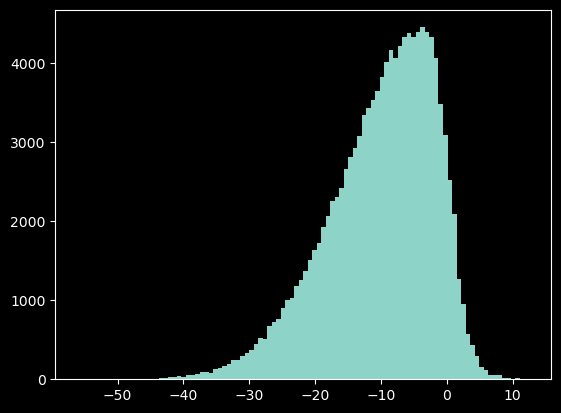

In [11]:
# val_grad_fn = jax.value_and_grad(A_star_cond_log_post, argnums=0, has_aux=True) 
val_grad_fn = jax.value_and_grad(A_star_cond_log_post_with_Y, argnums=0, has_aux=True) 

# (sum_logprob, log_prob), gradient = val_grad_fn(triu_star, triu_obs, df_edges, theta, gamma)
(sum_logprob, log_prob), gradient = val_grad_fn(triu_star, triu_obs, df_edges, theta, gamma, Y, x, Z, eta)
print(log_prob.shape, gradient.shape)
print(sum_logprob, "\n", gradient[1:10])

# create histogram of gradient

plt.hist(gradient, bins=100)

In [51]:
# create a function that `flip` triu_star value (0->1, 1->0), each at a time
#  and for each flip compute difference in log prob (sum)

@jax.jit
def edge_flip_loglik(triu_star, triu_obs, df_edges, theta, gamma, idx):
    new_triu_star = triu_star.at[idx].set(1 - triu_star[idx])
    _ ,log_prob = A_star_cond_log_post(new_triu_star[idx], triu_obs[idx], df_edges[idx,:], theta, gamma)
    return log_prob
    # return log_prob[idx]

# now wrap for all idx

@jax.jit
def flip_triu_star_all(triu_star, triu_obs, df_edges, theta, gamma, idx_set):
    return jnp.array([edge_flip_loglik(triu_star, triu_obs, df_edges, theta, gamma, idx) for idx in tqdm(idx_set)])

(124750,) (124750,)
flip check True
flip check 2 False
manual flip time 0.22102999687194824
(100,)


100%|██████████| 100/100 [00:00<00:00, 1946.06it/s]


func flip time 7.153838157653809
(100,)
True


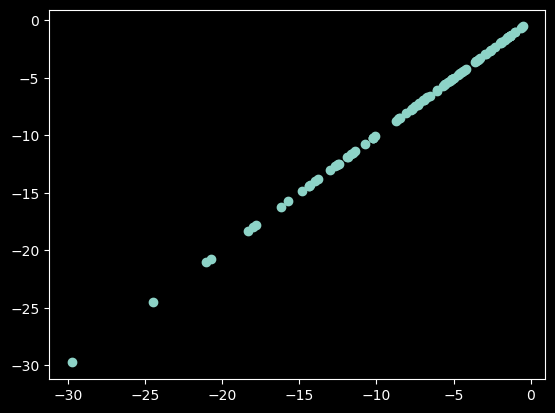

In [55]:
# samples idx_set as 100 values from triu_star

idx_set = random.choice(key, triu_dim, shape=(100,), replace=False)
# print(idx_set)

new_triu_star = triu_star.at[idx_set].set(1 - triu_star[idx_set])
print(triu_star.shape, new_triu_star.shape)

print("flip check", jnp.allclose(new_triu_star[idx_set], 1 - triu_star[idx_set]))
print("flip check 2", jnp.allclose(new_triu_star[idx_set],triu_star[idx_set]))


start = time.time()
_, manual_flip_loglik = A_star_cond_log_post(new_triu_star[idx_set], 
                                             triu_obs[idx_set],
                                               df_edges[idx_set,:],
                                                theta, gamma)
print("manual flip time", time.time() - start)

# manual_flip_loglik_min = manual_flip_loglik[idx_set]
print(manual_flip_loglik.shape)
# print(manual_flip_loglik_min.shape)

start = time.time()
func_flip_loglik = flip_triu_star_all(triu_star, triu_obs, df_edges, theta, gamma, idx_set)
print("func flip time", time.time() - start)

print(func_flip_loglik.shape)

print(jnp.allclose(manual_flip_loglik, func_flip_loglik))

plt.scatter(manual_flip_loglik, func_flip_loglik)

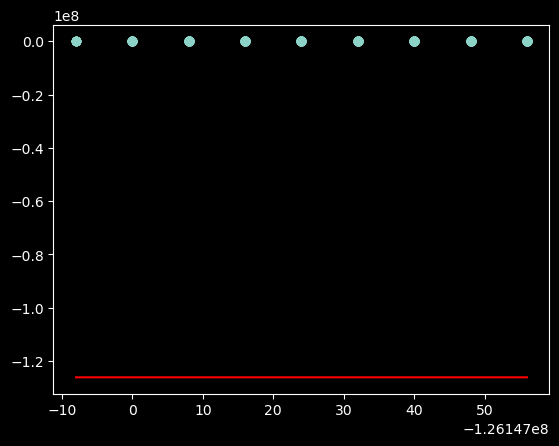

In [12]:
#  manual diff

# _, f_a = A_star_cond_log_post(triu_star, triu_obs, df_edges, theta, gamma)
# _, f_a_tag = A_star_cond_log_post(1-triu_star, triu_obs, df_edges, theta, gamma)
_, f_a = A_star_cond_log_post_with_Y(triu_star, triu_obs, df_edges, theta, gamma, Y, x, Z, eta)
_, f_a_tag = A_star_cond_log_post_with_Y(1-triu_star, triu_obs, df_edges, theta, gamma, Y, x, Z, eta)

grad_manual = f_a_tag - f_a

# score_grad = jnp.sum(-(2*triu_star-1)*gradient)
score_grad = -(2*triu_star-1)*gradient

# plt.hist(score_grad, bins=100)
plt.scatter(grad_manual, score_grad)
#  add y~x line
plt.plot([min(grad_manual), max(grad_manual)], [min(grad_manual), max(grad_manual)], color='red')
# plt.hist(grad_manual - score_grad, bins=100)

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        3.000e+00, 3.000e+00, 6.000e+00, 8.000e+00, 2.000e+00, 1.000e+01,
        6.000e+00, 8.000e+00, 5.000e+00, 8.000e+00, 1.700e+01, 1.500e+01,
        2.800e+01, 4.300e+01, 2.900e+01, 5.600e+01, 6.400e+01, 7.600e+01,
        1.000e+02, 1.090e+02, 1.130e+02, 1.640e+02, 1.640e+02, 2.170e+02,
        2.690e+02, 2.760e+02, 3.420e+02, 3.960e+02, 4.430e+02, 5.670e+02,
        5.810e+02, 7.250e+02, 8.250e+02, 8.710e+02, 1.030e+03, 1.184e+03,
        1.218e+03, 1.391e+03, 1.506e+03, 1.718e+03, 1.839e+03, 1.957e+03,
        2.253e+03, 2.415e+03, 2.605e+03, 2.690e+03, 2.929e+03, 3.147e+03,
        3.297e+03, 3.584e+03, 3.784e+03, 3.967e+03, 4.037e+03, 4.204e+03,
        4.475e+03, 4.633e+03, 4.518e+03, 4.681e+03, 4.788e+03, 4.788e+03,
        4.704e+03, 4.831e+03, 4.650e+03, 4.588e+03, 4.384e+03, 3.750e+03,
        3.464e+03, 2.417e+03, 1.961e+03, 1.514e+03, 9.890e+02, 7.130e+02,
        4.890e+02, 3.240e+02, 2.220e+0

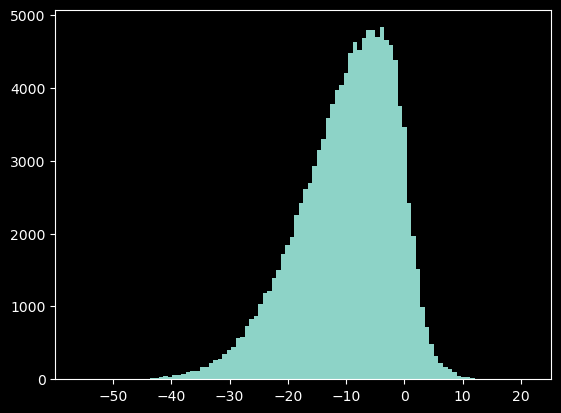

In [15]:
plt.hist(score_grad, bins=100)

In [16]:
# compare jax grad with manual grad running time by changing theta[0] values 


start = time.time()
for theta_0 in tqdm(jnp.arange(-3, -1, 0.001), desc = "jax grad"):
    c_theta = jnp.array([theta_0, 1.5])
    # (_, _), gradient = val_grad_fn(triu_star, triu_obs, df_edges, c_theta, gamma)
    (_, _), gradient = val_grad_fn(triu_star, triu_obs, df_edges, c_theta, gamma, Y, x, Z, eta)

print("jax time: ", time.time() - start)

start = time.time()
for theta_0 in tqdm(jnp.arange(-3, -1, 0.001), desc = "manual grad"):
    c_theta = np.array([theta_0, 1.5])
    _, f_a = A_star_cond_log_post_with_Y(triu_star, triu_obs, df_edges, c_theta, gamma, Y, x, Z, eta)
    _, f_a_tag = A_star_cond_log_post_with_Y(1-triu_star, triu_obs, df_edges, c_theta, gamma, Y, x, Z, eta)
    # _, f_a = A_star_cond_log_post(triu_star, triu_obs, df_edges, c_theta, gamma)
    # _, f_a_tag = A_star_cond_log_post(1-triu_star, triu_obs, df_edges, c_theta, gamma)
    grad_manual = f_a_tag - f_a

print("manual time: ", time.time() - start)



jax grad: 100%|██████████| 2000/2000 [00:21<00:00, 94.33it/s] 


jax time:  21.23240041732788


manual grad: 100%|██████████| 2000/2000 [00:18<00:00, 109.44it/s]

manual time:  18.275511741638184


In [10]:
print(grad_manual.shape, gradient.shape)

(124750,) (124750,)


min:  6.7267925e-13 max:  0.99997646 
 mean:  0.12435323 median:  0.012383345 
 q025:  5.64035e-07 q975:  0.8065115
min:  9.103724e-14 max:  0.999826 
 mean:  0.038734272 median:  0.0016940422 
 q025:  7.6333954e-08 q975:  0.36066028


(array([59818.,  8377.,  4950.,  3594.,  2919.,  2388.,  2036.,  1784.,
         1522.,  1431.,  1328.,  1223.,  1082.,  1093.,  1016.,   938.,
          918.,   835.,   733.,   783.,   729.,   746.,   726.,   611.,
          628.,   607.,   610.,   593.,   568.,   531.,   526.,   546.,
          516.,   500.,   501.,   523.,   419.,   449.,   454.,   386.,
          417.,   402.,   409.,   381.,   315.,   385.,   367.,   377.,
          373.,   357.,   370.,   356.,   372.,   327.,   351.,   259.,
          253.,   257.,   235.,   262.,   277.,   251.,   273.,   267.,
          267.,   274.,   242.,   230.,   231.,   233.,   247.,   207.,
          222.,   194.,   227.,   234.,   213.,   236.,   203.,   215.,
          198.,   175.,   177.,   153.,   180.,   161.,   161.,   192.,
          157.,   176.,   165.,   143.,   141.,   146.,   152.,   149.,
          140.,   159.,   178.,   142.]),
 array([6.72679252e-13, 9.99976415e-03, 1.99995283e-02, 2.99992934e-02,
        3.99990566e-02

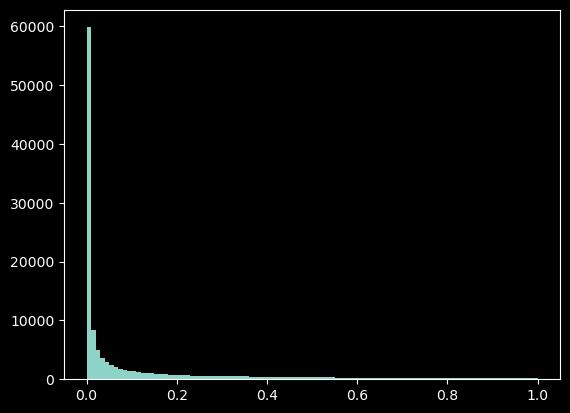

In [18]:
# grad_on_idx = (f_a_tag - f_a)/2
grad_on_idx = score_grad / 2

flip_probs = jnp.exp(grad_on_idx) / (jnp.exp(grad_on_idx) + 1)

# print summary of probs
print("min: ", jnp.min(flip_probs), "max: ", jnp.max(flip_probs), "\n",
      "mean: ", jnp.mean(flip_probs),
      "median: ", jnp.median(flip_probs), "\n",
      "q025: ", jnp.quantile(flip_probs, 0.025),
        "q975: ", jnp.quantile(flip_probs, 0.975))

flip_probs_rate = jnp.exp(grad_on_idx - 2) / (jnp.exp(grad_on_idx - 2) + 1)

# print summary of probs
print("min: ", jnp.min(flip_probs_rate), "max: ", jnp.max(flip_probs_rate), "\n",
      "mean: ", jnp.mean(flip_probs_rate),
      "median: ", jnp.median(flip_probs_rate), "\n",
      "q025: ", jnp.quantile(flip_probs_rate, 0.025),
        "q975: ", jnp.quantile(flip_probs_rate, 0.975))

plt.hist(flip_probs, bins=100)

In [19]:
# sample uniform[0,1] with dim as flip_probs_rate
# and compare with flip_probs_rate
flip_edges = random.uniform(key, shape=(triu_dim,)) < flip_probs_rate
print(flip_edges.mean(), flip_edges.sum())


0.03851703 4805


0.21046884 210.46883
0.03380498
9.357623e-14


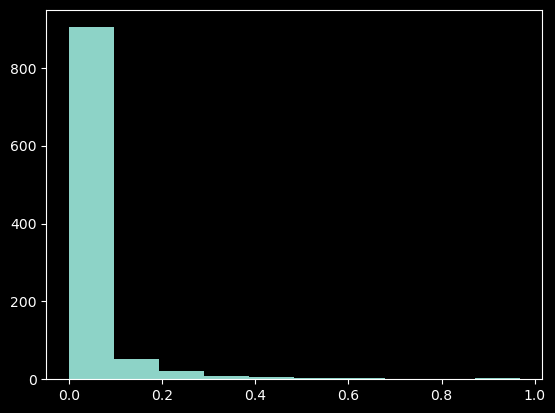

In [52]:
idxs = random.choice(key, triu_dim, shape=(1000,), replace=False)
prop_triu = triu_star.at[idxs].set(1 - triu_star[idxs])

_, tst_grad = val_grad_fn(triu_star, triu_obs, df_edges,
                                            theta, gamma, Y, x, Z, eta)
tst_grad = tst_grad[idxs]

temp_ratio = jnp.exp((-(2*triu_star[idxs]-1)*tst_grad)/2. - 2)
print(temp_ratio.mean(), temp_ratio.sum())
temp_ratio = jnp.clip(temp_ratio, -30, 30)
temp_prob = temp_ratio / (temp_ratio + 1)
print(temp_prob.mean())

plt.hist(temp_prob)

print(jnp.exp(-30) / (jnp.exp(-30) + 1))

In [53]:
TRIU_LEN = triu_star.shape[0]
BATCH_PROP = .1
BATCH_LEN = int(TRIU_LEN * BATCH_PROP)
# BATCH_LEN = 100


@jax.jit
def triu_star_update(triu_star, triu_obs, df_edges, theta, gamma,
                      Y, X, Z, eta, key, alpha = 0, eps = 1e-10):
    
    key1, key2, key3 = random.split(key, 3)
    # batch_size = (triu_star.shape[0]*batch_prop).astype(int)
    # sample mini-batch for potential edge flip
    idx_set = random.choice(key1, TRIU_LEN, 
                            shape=(BATCH_LEN,),
                              replace=False)
    # proposed raw new triu_star with edged flipped
    # proposed_triu_star = triu_star.at[idx_set].set(1 - triu_star[idx_set])

    # compute \tilde{f}(A*_t)
    # _, baseline_edge_loglik = A_star_cond_log_post(triu_star[idx_set],
    #                                                 triu_obs[idx_set],
    #                                                 df_edges[idx_set,:],
    #                                                 theta, gamma)
    # # compute \tilde{f}(\tilde{A}*_t)
    # _, proposed_edge_loglik = A_star_cond_log_post(proposed_triu_star[idx_set],
    #                                                 triu_obs[idx_set],
    #                                                 df_edges[idx_set,:],
    #                                                 theta, gamma)
    # Approximate with gradient
    (_,_), baseline_edge_loglik = val_grad_fn(triu_star, triu_obs, df_edges,
                                            theta, gamma, Y, x, Z, eta)
    baseline_edge_loglik = baseline_edge_loglik[idx_set]
    print(baseline_edge_loglik.shape)
    # compute \tilde{f}(\tilde{A}*_t)
    # (_,_), proposed_edge_loglik = val_grad_fn(proposed_triu_star, triu_obs, df_edges,
    #                                         theta, gamma, Y, x, Z, eta)[idx_set]
   
    # compute g(exp(d(\tilde{A}*_t, A*_t))) for g(a) = \sqrt{a} 
    # TODO: add step size by subtracting within the exp some rate $\alpha$ (can be adaptive)
    # temp_lik_ratio = jnp.exp((proposed_edge_loglik - baseline_edge_loglik)/2. - alpha)
    temp_lik_ratio = jnp.exp((-(2*triu_star[idx_set]-1)*baseline_edge_loglik)/2. - alpha)
    temp_lik_ratio = jnp.clip(temp_lik_ratio, -30, 30)

    # compute proposal probabilities q(\tilde{A}*_t|A*_t) \propto Softmax(exp(d(\tilde{A}*_t, A*_t)/2))
    forward_flip_probs = temp_lik_ratio / (temp_lik_ratio + 1)
    # sample flip indicator I
    flip_indicator = random.uniform(key2, shape=(BATCH_LEN,)) < forward_flip_probs
    # compute combined forward proposal q(\tilde{A}*_t|A*_t)
    forward_probs = forward_flip_probs * flip_indicator + (1 - forward_flip_probs) * (1 - flip_indicator)
    forward_proposal = jnp.sum(jnp.log(forward_probs + eps)) 

    # new proposed triu_star (after deciding which edges to flip)
    # it is proposed_triu_star with flipped edges only where flip_indicator is True
    new_triu_star = triu_star.at[idx_set].set(flip_indicator * (1 - triu_star[idx_set]) +
                                              (1 - flip_indicator) * triu_star[idx_set])

    
    # Backward proposal
    # _, new_edge_loglik = A_star_cond_log_post(new_triu_star[idx_set],
    #                                           triu_obs[idx_set],
    #                                           df_edges[idx_set,:],
    #                                           theta, gamma) 
    (_,_), new_edge_loglik = val_grad_fn(new_triu_star, triu_obs, df_edges,
                                            theta, gamma, Y, x, Z, eta)
    new_edge_loglik = new_edge_loglik[idx_set]
    # TODO: save here for step size $\alpha$
    # backward_temp_lik_ratio = jnp.exp((baseline_edge_loglik - proposed_edge_loglik)/2.)
    # backward_temp_lik_ratio = jnp.exp((baseline_edge_loglik - new_edge_loglik)/2. - alpha)
    backward_temp_lik_ratio = jnp.exp((-(2*triu_star[idx_set]-1)*new_edge_loglik)/2. - alpha)
    backward_temp_lik_ratio = jnp.clip(backward_temp_lik_ratio, -30, 30)

    # backward_temp_lik_ratio = jnp.exp((baseline_edge_loglik - proposed_edge_loglik)/2. - alpha)
    backward_flip_probs = backward_temp_lik_ratio / (backward_temp_lik_ratio + 1)
    backward_probs = backward_flip_probs * flip_indicator + (1 - backward_flip_probs) * (1 - flip_indicator)
    backward_proposal = jnp.sum(jnp.log(backward_probs + eps))

    # compute full (f) log-posterior diff $f(A*_new) - f(A*_baseline)$
    # f_baseline, _ = A_star_cond_log_post(triu_star, triu_obs, df_edges,
    #                                              theta, gamma)
    # f_proposed, _ = A_star_cond_log_post(new_triu_star, triu_obs, df_edges,
    #                                               theta, gamma)
    f_baseline, _ = A_star_cond_log_post_with_Y(triu_star, triu_obs, df_edges,
                                                 theta, gamma,
                                                 Y, X, Z, eta)
    f_proposed, _ = A_star_cond_log_post_with_Y(new_triu_star, triu_obs, df_edges,
                                                  theta, gamma,
                                                  Y, X, Z, eta)
    
#     print("forward proposal: ", forward_proposal, "\n",
#            "backward proposal: ", backward_proposal)
    # compute acceptance ratio
    acceptance_ratio = jnp.clip(jnp.exp(f_proposed - f_baseline + backward_proposal - forward_proposal),
                                a_max=1)
    # TODO: save acceptance ratio for diagnostics and adaptive step size
    # accept or reject
    accept = random.uniform(key3) <= acceptance_ratio

    # if i % 100 == 0:
    #     print("prop flipped from possible: ", flip_indicator.mean(), "; total:" , flip_indicator.sum())
    #     print("Update triu_star: ", accept, "; Acceptance prob:", acceptance_ratio)
    #     print("full posterior diff: ", f_proposed - f_baseline)
    #     print("reverse proposal diff", backward_proposal - forward_proposal)
#     print("Update triu_star: ", accept, "; Acceptance prob:", acceptance_ratio)
    # update triu_star
    new_triu_star = jax.lax.select(accept, new_triu_star, triu_star)
    return new_triu_star,idx_set,forward_flip_probs.mean(), acceptance_ratio, flip_indicator.mean(), f_proposed - f_baseline, backward_proposal - forward_proposal, temp_lik_ratio.mean()
    
     

In [54]:
# make noisy triu_star

triu_star_noisy = (triu_star * random.binomial(key, n=1, p=0.9, shape=(triu_dim,)) +
                   (1-triu_star) * random.binomial(key, n=1, p=0.1, shape=(triu_dim,)))

# test A_star update
# triu_len = triu_star_noisy.shape[0]
# batch_prop = 0.5
# batch_len = int(triu_len * batch_prop)
# new_triu_star = triu_star_update(triu_star_noisy, triu_obs, df_edges,
#                                   theta, gamma, Y, x, Z, eta, key,
#                                    triu_len, batch_len)

n_iter = 1000
new_triu_star = triu_star_noisy
exposures_lst = [compute_exposures(new_triu_star, Z)]
for i in tqdm(range(int(n_iter))):
    key, _ = random.split(key)
    new_triu_star, idx_set, fprob, acc, ind, f_p, ftild_p, b = triu_star_update(new_triu_star, triu_obs, df_edges,
                                      theta, gamma, Y, x, Z, eta, key)
    exposures_lst.append(compute_exposures(new_triu_star, Z))
    if i % 100 == 0:
        print("key: ", key)
        print("idx_set: ", idx_set)
        print("flip prob mean: ", fprob)
        print("Acceptance rate: ", acc.mean())
        print("prop flipped from possible: ", ind)
        print("full posterior diff: ", f_p)
        print("reverse proposal diff", ftild_p)
        print("temp lik ratio mean: ", b)


  0%|          | 0/1000 [00:00<?, ?it/s]

(12475,)


  0%|          | 2/1000 [00:03<22:00,  1.32s/it]

key:  [3983299879 1741180289]
idx_set:  [ 63662  72723  24030 ... 110564 124194 102044]
flip prob mean:  0.14579067
Acceptance rate:  1.0
prop flipped from possible:  0.14541082
full posterior diff:  342290.12
reverse proposal diff -58.498657
temp lik ratio mean:  3.7810504


 10%|█         | 102/1000 [00:14<01:37,  9.18it/s]

key:  [ 516323639 1895465887]
idx_set:  [ 25572  68371  16849 ...  83807  40074 120490]
flip prob mean:  0.1294082
Acceptance rate:  0.0
prop flipped from possible:  0.13058117
full posterior diff:  -13850.359
reverse proposal diff -17381.281
temp lik ratio mean:  2.7156081


 20%|██        | 203/1000 [00:26<01:25,  9.35it/s]

key:  [ 996144402 3412982269]
idx_set:  [119596  25752 120622 ...  59611  16124  98751]
flip prob mean:  0.12722906
Acceptance rate:  0.0
prop flipped from possible:  0.12881763
full posterior diff:  -6886.7188
reverse proposal diff -16809.83
temp lik ratio mean:  2.630062


 30%|███       | 302/1000 [00:38<01:21,  8.61it/s]

key:  [1094682674 4110697194]
idx_set:  [112969  48109  47503 ...  82470  41412  82916]
flip prob mean:  0.13180557
Acceptance rate:  0.0
prop flipped from possible:  0.1323447
full posterior diff:  -9262.734
reverse proposal diff -17174.695
temp lik ratio mean:  2.801608


 40%|████      | 402/1000 [00:50<01:09,  8.62it/s]

key:  [2866972656 1765091880]
idx_set:  [111433  13234 101902 ...  34114  52138  67010]
flip prob mean:  0.126207
Acceptance rate:  0.0
prop flipped from possible:  0.12633267
full posterior diff:  -2587.2812
reverse proposal diff -15861.877
temp lik ratio mean:  2.668129


 50%|█████     | 501/1000 [01:01<00:55,  8.96it/s]

key:  [ 212356436 1493059994]
idx_set:  [ 11847 104951  39272 ... 112626   3865  33692]
flip prob mean:  0.13119178
Acceptance rate:  0.0
prop flipped from possible:  0.13058117
full posterior diff:  -11734.094
reverse proposal diff -16006.497
temp lik ratio mean:  2.695559


 60%|██████    | 602/1000 [01:13<00:40,  9.94it/s]

key:  [3552903402 1629556858]
idx_set:  [109235 102662  14929 ...  45546  38973  58941]
flip prob mean:  0.12962984
Acceptance rate:  0.0
prop flipped from possible:  0.12825651
full posterior diff:  -15464.8125
reverse proposal diff -16788.268
temp lik ratio mean:  2.6595771


 70%|███████   | 703/1000 [01:24<00:30,  9.77it/s]

key:  [2206977081 2498148289]
idx_set:  [ 61250  50632  61601 ... 102822  43218  22061]
flip prob mean:  0.13209929
Acceptance rate:  0.0
prop flipped from possible:  0.13130261
full posterior diff:  -7531.9062
reverse proposal diff -16734.46
temp lik ratio mean:  2.755251


 80%|████████  | 802/1000 [01:34<00:19, 10.17it/s]

key:  [3108064220 2234575401]
idx_set:  [86681 94939 25330 ... 67077 29568 16991]
flip prob mean:  0.12958942
Acceptance rate:  0.0
prop flipped from possible:  0.12985973
full posterior diff:  -17969.906
reverse proposal diff -17236.174
temp lik ratio mean:  2.7565012


 90%|█████████ | 902/1000 [01:44<00:11,  8.84it/s]

key:  [2642616066 2469148740]
idx_set:  [  6676  65009 108139 ...   5818  43160  92345]
flip prob mean:  0.12888388
Acceptance rate:  0.0
prop flipped from possible:  0.1288978
full posterior diff:  -10024.453
reverse proposal diff -16699.873
temp lik ratio mean:  2.724593


100%|██████████| 1000/1000 [01:55<00:00,  8.63it/s]


In [ ]:
# TODO: add adaptive step size for alpha to obtain acceptance rate (of edges flip) around 0.574 (optimal)
# TODO: see tradeoff between number BATCH_LEN and acceptance rate
# TODO: check if some terms are canceled in the final acceptance ratio due to the lack of use of the outcome model in edge propsal

(1001, 500)
12.596001


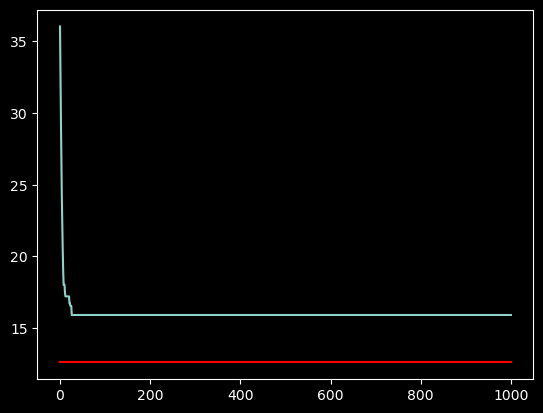

In [55]:
expos_arr = jnp.array(exposures_lst)
print(expos_arr.shape)
print(exposures.mean())
# plt.scatter(expos_arr.mean(axis=1), jnp.ones(expos_arr.shape[0])*exposures.mean())
# print(expos_arr.mean(axis=1))
# create line plot of expos_arr.mean(axis=1) (y axis) vs the index (x axis)
plt.plot(expos_arr.mean(axis=1))
plt.plot(jnp.ones(expos_arr.shape[0])*exposures.mean(), color='red')

In [194]:
TRIU_LEN*0.01

1247.5